In [1]:
# =============================
# Install (uncomment if running in a fresh environment)
# =============================
!pip install requests pandas matplotlib seaborn

In [2]:
# =============================
# Import Required Libraries
# =============================
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys

In [3]:
# =============================
# Step 1: API Configuration
# =============================
API_KEY = "f9f5b60b83f7c53d84292c35973e7dcf"   # <-- Replace with your OpenWeatherMap API key
CITY = "Chennai"           # <-- Change to any city you want
BASE_URL = "https://api.openweathermap.org/data/2.5/forecast"  # 5-day / 3-hour forecast
UNITS = "metric"  # "metric" -> Celsius, "imperial" -> Fahrenheit

params = {
    "q": CITY,
    "appid": API_KEY,
    "units": UNITS
}

# Quick safety check for API key
if API_KEY in (None, "", "YOUR_API_KEY"):
    raise ValueError("Please replace API_KEY with your OpenWeatherMap API key before running.")

In [4]:
# =============================
# Step 2: Fetch Data
# =============================
try:
    response = requests.get(BASE_URL, params=params, timeout=15)
    response.raise_for_status()   # raise an HTTPError for bad responses (4xx or 5xx)
except requests.exceptions.RequestException as e:
    print("❌ Error fetching data from OpenWeatherMap:", e)
    sys.exit(1)

data = response.json()

# Basic validation
if 'list' not in data or not isinstance(data['list'], list):
    print("❌ Unexpected API response structure. Full response:")
    print(data)
    raise SystemExit

print("✅ Data fetched successfully!")

✅ Data fetched successfully!


In [5]:
# =============================
# Step 3: Parse & Build DataFrame
# =============================
weather_data = []
for forecast in data['list']:
    # forecast['dt_txt'] is e.g. "2025-09-26 12:00:00"
    dt_text = forecast.get('dt_txt')
    main = forecast.get('main', {})
    wind = forecast.get('wind', {})
    weather_desc = ""
    try:
        # 'weather' is a list; first item has 'description'
        weather_desc = forecast.get('weather', [{}])[0].get('description', "")
    except Exception:
        weather_desc = ""

    weather_data.append({
        "datetime": dt_text,
        "temperature": main.get('temp'),
        "feels_like": main.get('feels_like'),
        "humidity": main.get('humidity'),
        "pressure": main.get('pressure'),
        "weather": weather_desc.title(),  # Title case for nicer labels
        "wind_speed": wind.get('speed'),
        "clouds_pct": forecast.get('clouds', {}).get('all')
    })

# Create DataFrame and convert datetime column
df = pd.DataFrame(weather_data)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime').sort_index()

# Quick data sanity: drop rows with no temperature information
df = df[df['temperature'].notna()]

# Show preview (Jupyter will nicely render this)
display(df.head(8))

,temperature,feels_like,humidity,pressure,weather,wind_speed,clouds_pct
datetime,,,,,,,
2025-11-15 06:00:00,28.88,34.00,78,1014,Scattered Clouds,6.47,40
2025-11-15 09:00:00,28.60,32.04,71,1013,Broken Clouds,6.54,58
2025-11-15 12:00:00,27.22,29.42,72,1013,Broken Clouds,6.59,78
2025-11-15 15:00:00,26.12,26.12,70,1015,Overcast Clouds,6.34,100
2025-11-15 18:00:00,26.02,26.02,71,1014,Overcast Clouds,6.11,100
2025-11-15 21:00:00,25.50,25.99,72,1013,Overcast Clouds,5.46,100
2025-11-16 00:00:00,24.73,25.19,74,1013,Overcast Clouds,6.19,100
2025-11-16 03:00:00,25.69,26.17,71,1016,Overcast Clouds,6.49,100


/tmp/ipython-input-1703456707.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax, y="weather", data=df, order=order, palette="viridis")


📌 Dashboard saved to: Chennai_weather_dashboard.png


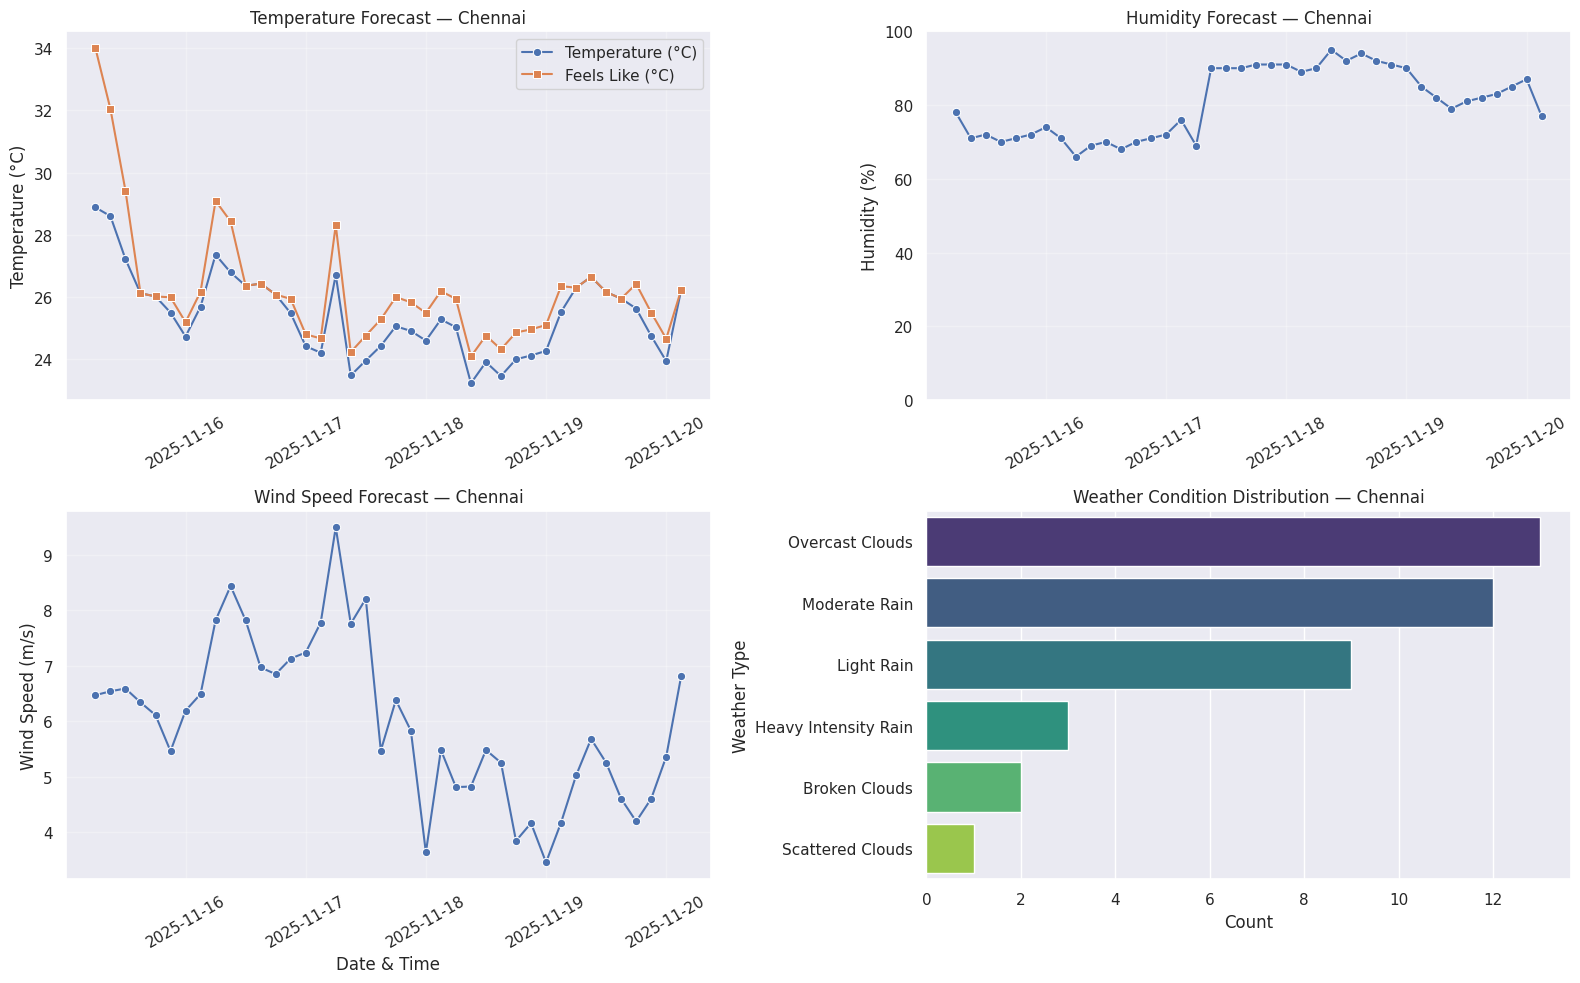

In [6]:
# =============================
# Step 4: Create Dashboard Plots
# =============================
sns.set(style="darkgrid")
plt.rcParams.update({'figure.autolayout': True})
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2x2 grid dashboard

# ---- (1) Temperature Trend ----
ax = axes[0, 0]
sns.lineplot(ax=ax, x=df.index, y="temperature", data=df, marker="o", label="Temperature (°C)")
sns.lineplot(ax=ax, x=df.index, y="feels_like", data=df, marker="s", label="Feels Like (°C)")
ax.set_title(f"Temperature Forecast — {CITY}")
ax.set_xlabel("")
ax.set_ylabel("Temperature (°C)")
ax.tick_params(axis="x", rotation=30)
ax.legend()
ax.grid(True, alpha=0.3)

# ---- (2) Humidity Trend ----
ax = axes[0, 1]
sns.lineplot(ax=ax, x=df.index, y="humidity", data=df, marker="o")
ax.set_title(f"Humidity Forecast — {CITY}")
ax.set_xlabel("")
ax.set_ylabel("Humidity (%)")
ax.tick_params(axis="x", rotation=30)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

# ---- (3) Wind Speed Trend ----
ax = axes[1, 0]
sns.lineplot(ax=ax, x=df.index, y="wind_speed", data=df, marker="o")
ax.set_title(f"Wind Speed Forecast — {CITY}")
ax.set_xlabel("Date & Time")
ax.set_ylabel("Wind Speed (m/s)")
ax.tick_params(axis="x", rotation=30)
ax.grid(True, alpha=0.3)

# ---- (4) Weather Conditions Count ----
ax = axes[1, 1]
# We want to show counts ordered by frequency (most common at top)
order = df['weather'].value_counts().index
sns.countplot(ax=ax, y="weather", data=df, order=order, palette="viridis")
ax.set_title(f"Weather Condition Distribution — {CITY}")
ax.set_xlabel("Count")
ax.set_ylabel("Weather Type")

plt.tight_layout()

# Save the dashboard image for submission
output_filename = f"{CITY.replace(' ', '_')}_weather_dashboard.png"
fig.savefig(output_filename, dpi=150)
print(f"📌 Dashboard saved to: {output_filename}")

plt.show()

In [7]:
# =============================
# Step 5: Summary Statistics
# =============================
print("\n📌 DASHBOARD SUMMARY")
print(f"City: {CITY}")
print(f"Data points: {len(df)} (each point is a 3-hour forecast within the 5-day window)")
if not df.empty:
    print(f"Temperature Range: {df['temperature'].min():.1f}°C to {df['temperature'].max():.1f}°C")
    print(f"Average Temperature: {df['temperature'].mean():.2f}°C")
    print(f"Average Humidity: {df['humidity'].mean():.2f}%")
    print(f"Most Common Weather Condition: {df['weather'].mode().iloc[0]}")
else:
    print("No valid forecast data available.")



📌 DASHBOARD SUMMARY
City: Chennai
Data points: 40 (each point is a 3-hour forecast within the 5-day window)
Temperature Range: 23.2°C to 28.9°C
Average Temperature: 25.44°C
Average Humidity: 80.67%
Most Common Weather Condition: Overcast Clouds
